# setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

/opt/conda/envs/quant/lib/python3.12/site-packages/vnai/scope/profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# load data

In [12]:
def get_symbols_by_group(group_name):
    listing = Listing()
    return listing.symbols_by_group(group_name)

def fetch_history_for_symbols(symbols, start='2010-01-01', end='2025-08-25', interval='1D'):
    all_data = []
    for symbol in symbols:
        quote = Quote(symbol=symbol, source='VCI')
        df = quote.history(start=start, end=end, interval=interval)
        df['symbol'] = symbol
        all_data.append(df)
    result = pd.concat(all_data, ignore_index=True)
    result['time'] = pd.to_datetime(result['time'])
    return result

def save_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Đã lưu dữ liệu vào {filepath}")

def filter_data_by_symbol(symbol, df, start=None, end=None):
    df.index = pd.to_datetime(df.index)
    if start is None:
        start = df.index.min()
    if end is None:
        end = df.index.max()
    return df[(df['symbol'] == symbol) & (df.index >= start) & (df.index <= end)]

In [8]:
# Fetch VN30F1M (nearest month VN30 futures) historical data using vnstock
vn30f1m_quote = Quote(symbol='VN30F1M', source='VCI')
vn30f1m_index = vn30f1m_quote.history(start='2018-01-01', end='2025-08-25', interval='1D')
vn30f1m_index['time'] = pd.to_datetime(vn30f1m_index['time'])
vn30f1m_index = vn30f1m_index.set_index('time')
vn30f1m_index.head()

open    high     low   close  volume
time                                              
2018-01-02   983.9   999.0   980.8   999.0   11347
2018-01-03  1002.5  1015.2  1002.0  1012.8   16134
2018-01-04  1014.8  1023.9  1012.8  1023.9   13815
2018-01-05  1024.1  1025.0  1007.0  1012.0   16296
2018-01-08  1008.3  1031.0  1005.7  1030.0   13326

In [9]:
# Fetch VN30 index historical data using vnstock
vn30_quote = Quote(symbol='VN30', source='VCI')
vn30_index = vn30_quote.history(start='2010-01-01', end='2025-08-25', interval='1D')
vn30_index['time'] = pd.to_datetime(vn30_index['time'])
vn30_index = vn30_index.set_index('time')
vn30_index.head()

open    high     low   close    volume
time                                                
2012-02-06  447.47  447.47  447.47  447.47  13467070
2012-02-07  449.31  449.31  449.31  449.31  17261070
2012-02-08  460.98  460.98  460.98  460.98  20406280
2012-02-09  464.73  464.73  464.73  464.73  20379320
2012-02-10  458.23  458.23  458.23  458.23  20816360

In [10]:
data_all = pd.read_csv('data/vn30_history.csv')
data_all = data_all.set_index('time')
data_all.head()

open  high   low  close   volume symbol
time                                               
2010-01-04  3.71  3.97  3.69   3.97  2765900    ACB
2010-01-05  4.06  4.14  3.94   3.97  1929200    ACB
2010-01-06  3.96  4.01  3.86   3.86  1303300    ACB
2010-01-07  3.95  3.97  3.84   3.86  1342000    ACB
2010-01-08  3.87  4.01  3.80   3.83  1461300    ACB

In [14]:
df_hpg = filter_data_by_symbol('HPG',df=data_all)
df_hpg.head()

open  high   low  close   volume symbol
time                                               
2010-01-04  1.47  1.49  1.47   1.49   603120    HPG
2010-01-05  1.56  1.56  1.49   1.56  1203080    HPG
2010-01-06  1.55  1.61  1.54   1.61  1771660    HPG
2010-01-07  1.64  1.68  1.61   1.66  1535800    HPG
2010-01-08  1.70  1.70  1.59   1.59   909010    HPG

# first try on hpg

In [32]:
def calculate_rsi(series, period=14):
    """
    Tính toán chỉ số RSI (Relative Strength Index).
    """
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def run_adftest(series: pd.Series, start_date: str, end_date: str, series_name: str = 'Chuỗi thời gian'):
    """
    Kiểm tra tính dừng của một chuỗi thời gian trong một khoảng thời gian cụ thể và in kết quả.
1
        series (pd.Series): Chuỗi thời gian (ví dụ: chuỗi giá đóng cửa).
        start_date (str): Ngày bắt đầu ('YYYY-MM-DD').
        end_date (str): Ngày kết thúc ('YYYY-MM-DD').
        series_name (str): Tên của chuỗi để hiển thị trong báo cáo.
    """
    print(f"--- Kiểm tra tính dừng cho: {series_name} ---")
    print(f"Thời gian kiểm tra: từ {start_date} đến {end_date}\n")
    
    try:
        # Lọc chuỗi thời gian theo khoảng ngày
        period_series = series.loc[start_date:end_date].dropna()
        
        if period_series.empty:
            print("Lỗi: Không tìm thấy dữ liệu hoặc dữ liệu rỗng trong khoảng đã chọn.")
            return

        # Thực hiện kiểm tra ADF trên logarit của chuỗi
        log_series = np.log(period_series)
        result = adfuller(log_series)
        
        # In kết quả
        print(f"Giá trị thống kê ADF: {result[0]:.4f}")
        print(f"p-value: {result[1]:.4f}")
        print(f"Số độ trễ được sử dụng: {result[2]}")
        print(f"Số quan sát: {result[3]}")
        print("Giá trị ngưỡng:")
        for key, value in result[4].items():
            print(f"\t{key}: {value:.4f}")
        
        # Đưa ra kết luận
        print("\n--- Kết luận ---")
        if result[1] <= 0.05:
            print(f"⭐ p-value ({result[1]:.4f}) nhỏ hơn 0.05.")
            print("Chuỗi thời gian này CÓ tính dừng trong giai đoạn đã chọn.")
        else:
            print(f"❌ p-value ({result[1]:.4f}) lớn hơn 0.05.")
            print("Chuỗi thời gian này KHÔNG có tính dừng trong giai đoạn đã chọn.")
            print("Điều này cho thấy có xu hướng (trend) và không phù hợp với chiến lược mean reversion đơn thuần.")
            
    except Exception as e:
        print(f"Có lỗi xảy ra trong quá trình kiểm tra: {e}")
    print('---------------------------------\n')
    
def find_half_life(series: pd.Series):
    """
    Tìm Half-life của một chuỗi thời gian bằng hồi quy OLS.
    
    Args:
        series (pd.Series): Chuỗi thời gian đã được xác nhận là có tính dừng.
        
    Returns:
        float: Giá trị Half-life.
    """
    # Loại bỏ các giá trị NaN
    series = series.dropna()

    # Tạo chuỗi Delta (dòng 1) và Lagged Series (dòng 2)
    delta_series = series.diff().dropna()
    lagged_series = series.shift(1).loc[delta_series.index]

    # Thêm hằng số vào mô hình hồi quy
    lagged_series = sm.add_constant(lagged_series)

    # Chạy hồi quy OLS
    model = sm.OLS(delta_series, lagged_series)
    results = model.fit()

    # Lấy hệ số beta
    beta = results.params.iloc[1]

    # Tính Half-life
    half_life = -np.log(2) / beta
    
    return half_life, results.summary()

In [36]:
# Chạy kiểm tra cho một khoảng thời gian cụ thể
rsi_series = calculate_rsi(df_hpg['close'])

run_adftest(
    series=rsi_series,
    start_date='2015-01-01',
    end_date='2025-08-25',
    series_name='RSI'
)

# 2. Tìm half-life của chuỗi RSI
half_life, regression_summary = find_half_life(rsi_series)

print(f"Half-life của chuỗi RSI HPG: {half_life:.2f} ngày")

--- Kiểm tra tính dừng cho: RSI ---
Thời gian kiểm tra: từ 2015-01-01 đến 2025-08-25

Giá trị thống kê ADF: -6.8642
p-value: 0.0000
Số độ trễ được sử dụng: 28
Số quan sát: 2629
Giá trị ngưỡng:
	1%: -3.4328
	5%: -2.8626
	10%: -2.5674

--- Kết luận ---
⭐ p-value (0.0000) nhỏ hơn 0.05.
Chuỗi thời gian này CÓ tính dừng trong giai đoạn đã chọn.
---------------------------------

Half-life của chuỗi RSI HPG: 8.94 ngày


ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Chain

Lợi nhuận tích lũy của chiến lược: 1.00
Lợi nhuận của chiến lược Buy & Hold: 10.00


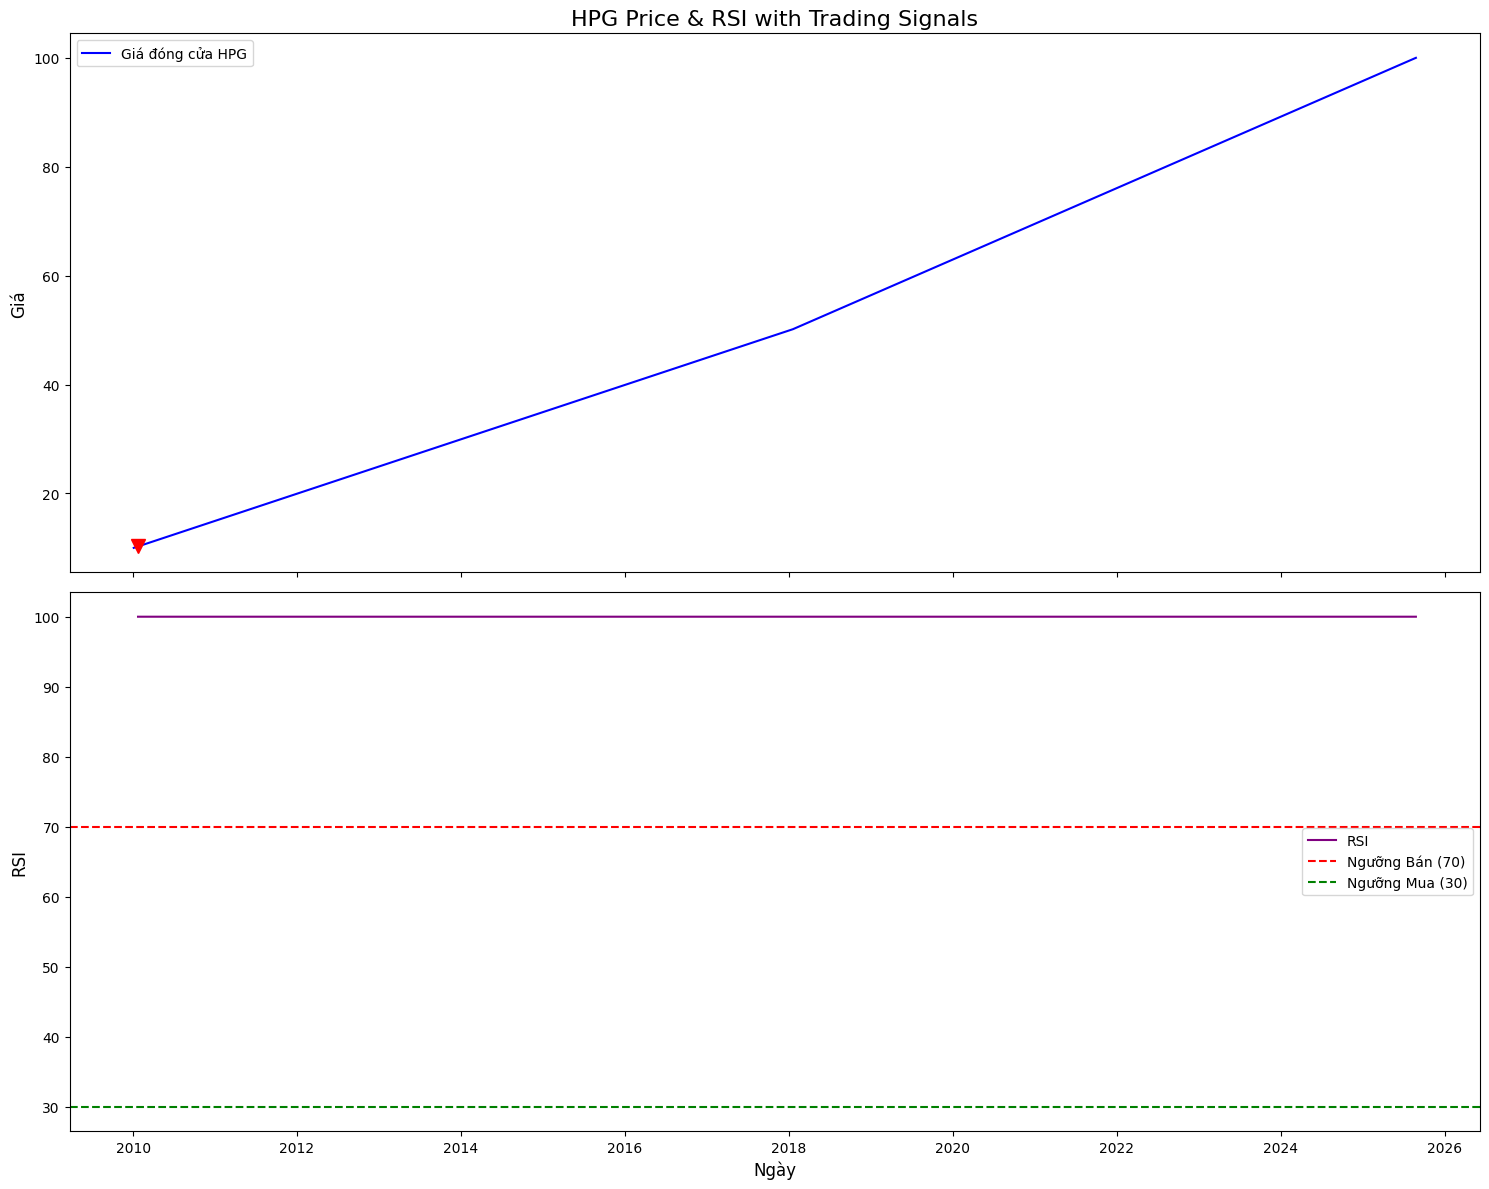

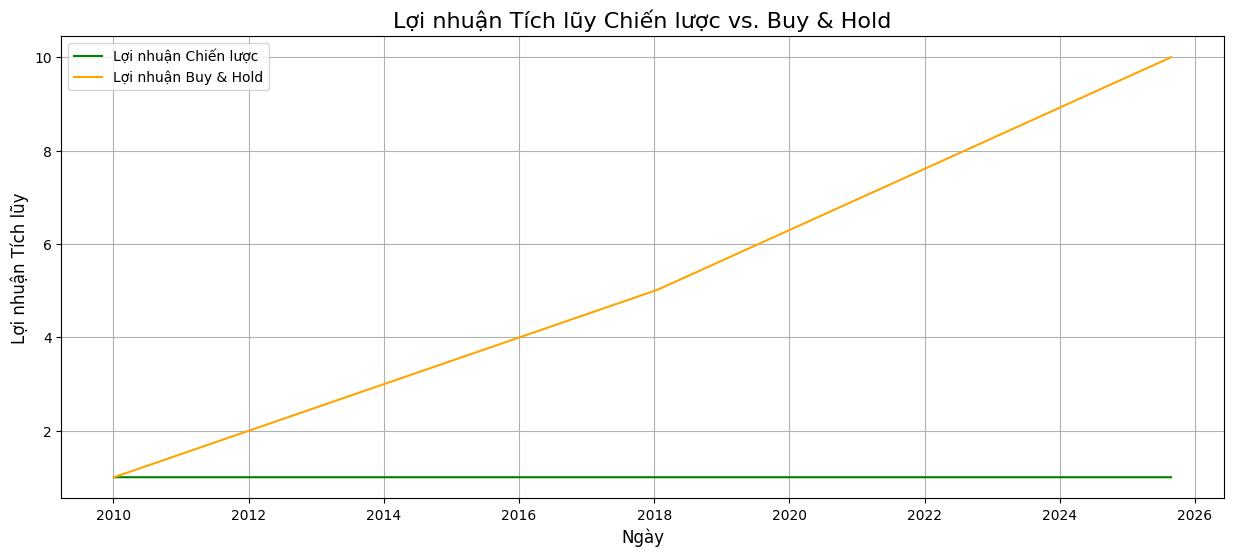

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rsi(series, period=14):
    """Tính toán chỉ số RSI."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_rsi_mean_reversion(df, rsi_period=14, buy_level=30, sell_level=70):
    """
    Backtest chiến lược mean reversion dựa trên RSI.
    """
    df = df.copy()
    df['rsi'] = calculate_rsi(df['close'], period=rsi_period)
    df['signal'] = 0
    df.loc[df['rsi'] < buy_level, 'signal'] = 1   # Mua khi RSI < buy_level
    df.loc[df['rsi'] > sell_level, 'signal'] = -1 # Bán/chốt lời khi RSI > sell_level

    # Tạo cột position: 1 nếu đang giữ cổ phiếu, 0 nếu không
    df['position'] = 0
    holding = False
    for i in range(1, len(df)):
        if df['signal'].iloc[i] == 1 and not holding:
            holding = True
        elif df['signal'].iloc[i] == -1 and holding:
            holding = False
        df['position'].iloc[i] = 1 if holding else 0

    df['returns'] = df['close'].pct_change()
    df['strategy_returns'] = df['position'].shift().fillna(0) * df['returns']
    df['cum_strategy_returns'] = (1 + df['strategy_returns']).cumprod()
    return df

def plot_backtest_results(df):
    """Vẽ biểu đồ kết quả backtest."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Biểu đồ giá và RSI
    ax1.plot(df.index, df['close'], label='Giá đóng cửa HPG', color='blue')
    ax1.set_title('HPG Price & RSI with Trading Signals', fontsize=16)
    ax1.set_ylabel('Giá', fontsize=12)
    ax1.legend()

    # Biểu đồ RSI
    ax2.plot(df.index, df['rsi'], label='RSI', color='purple')
    ax2.axhline(70, linestyle='--', color='red', label='Ngưỡng Bán (70)')
    ax2.axhline(30, linestyle='--', color='green', label='Ngưỡng Mua (30)')
    ax2.set_ylabel('RSI', fontsize=12)
    ax2.set_xlabel('Ngày', fontsize=12)
    ax2.legend()

    # Đánh dấu điểm mua
    buy_signals = df[(df['signal'].diff() == 1)]
    ax1.plot(buy_signals.index, buy_signals['close'], '^', markersize=10, color='green', label='Mua')

    # Đánh dấu điểm bán
    sell_signals = df[(df['signal'].diff() == -1)]
    ax1.plot(sell_signals.index, sell_signals['close'], 'v', markersize=10, color='red', label='Bán/Chốt lời')

    plt.tight_layout()
    plt.show()

    # Biểu đồ lợi nhuận tích lũy
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['cum_strategy_returns'], label='Lợi nhuận Chiến lược', color='green')
    plt.plot(df.index, (1 + df['returns']).cumprod(), label='Lợi nhuận Buy & Hold', color='orange')
    plt.title('Lợi nhuận Tích lũy Chiến lược vs. Buy & Hold', fontsize=16)
    plt.xlabel('Ngày', fontsize=12)
    plt.ylabel('Lợi nhuận Tích lũy', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Phần chạy backtest ---

# Giả lập DataFrame df_hpg
data = {
    'close': np.concatenate([np.linspace(10, 50, 2000), np.linspace(50, 100, 1903)]),
}
df_hpg = pd.DataFrame(data, index=pd.to_datetime(pd.date_range(start='2010-01-04', end='2025-08-25', periods=3903)))

# Chạy backtest
backtest_results = backtest_rsi_mean_reversion(df_hpg)

# In kết quả
final_return = backtest_results['cum_strategy_returns'].iloc[-1]
buy_hold_return = (1 + backtest_results['returns']).cumprod().iloc[-1]

print(f"Lợi nhuận tích lũy của chiến lược: {final_return:.2f}")
print(f"Lợi nhuận của chiến lược Buy & Hold: {buy_hold_return:.2f}")

# Vẽ biểu đồ
plot_backtest_results(backtest_results)